# Cours "Géomatique"
### Louis Maritaud
### louis.maritaud@unilim.fr

## Objectifs pédagogiques
- Comprendre la structure d'un GeoDataFrame
- Lire et manipuler des fichiers géographiques
- Maîtriser les bases des systèmes de coordonnées (CRS)
- Créer des cartes simples avec matplotlib


## Partie Théorique

### 1. Introduction à GeoPandas

**Qu'est-ce que GeoPandas ?**
- Extension de Pandas pour les données géographiques
- Même syntaxe que Pandas + colonne spéciale `geometry`
- Supporte shapefile, GeoJSON, GeoPackage, etc.
- Intégration avec matplotlib pour la visualisation

In [52]:
#Installation et imports
# Installation (à faire une fois)
# conda install geopandas matplotlib contextily

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Construction d'un DataFrame classique 
df = pd.DataFrame({
    'ville': ['Paris', 'Lyon', 'Marseille', 'Toulouse', 'Limoges'],
    'population': [2103778, 519127, 877215, 514819, 129754], # Données Wikipédia
    'latitude': [48.8566, 45.7640, 43.2965, 43.6048, 45.849998],
    'longitude': [2.3522, 4.8357, 5.3698, 1.4428, 1.25]
})

print(f"Notre DataFrame classique : \n{df}")

Notre DataFrame classique : 
       ville  population   latitude  longitude
0      Paris     2103778  48.856600     2.3522
1       Lyon      519127  45.764000     4.8357
2  Marseille      877215  43.296500     5.3698
3   Toulouse      514819  43.604800     1.4428
4    Limoges      129754  45.849998     1.2500


<class 'geopandas.geodataframe.GeoDataFrame'>

Colonne geometry :
0    POINT (2.3522 48.8566)
1     POINT (4.8357 45.764)
2    POINT (5.3698 43.2965)
3    POINT (1.4428 43.6048)
4        POINT (1.25 45.85)
Name: geometry, dtype: geometry

Type de la colonne geometry :<class 'geopandas.geoseries.GeoSeries'>


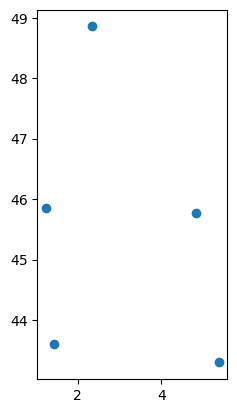

In [57]:
# Conversion en GeoDataFrame
# Créer des géométries Point à partir des coordonnées → points_from_xy
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # Système de coordonnées WGS84
)

print(gdf)
print(f"\nColonne geometry :\n{gdf.geometry}")
print(f"\nType de la colonne geometry :{type(gdf.geometry)}")

gdf.plot()
plt.show()


<Axes: >

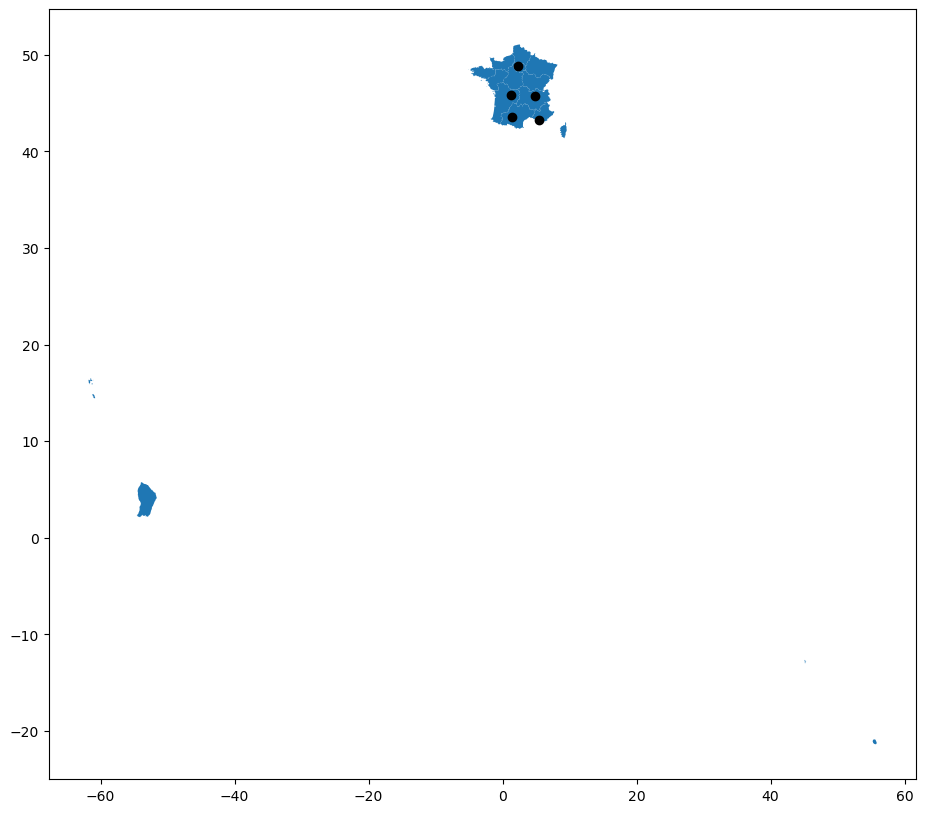

In [69]:
# Ajout du geojson des régions : 
gdf_regions=gpd.read_file("DATA/regions.geojson") #On lit le geojson et on en fait un geodataframe
ax = gdf_regions.plot(figsize=(20, 10)) # On créé un premier plot à partir du geojson
gdf.plot(ax=ax, color="black") # On ajout à ce premier plot nos points

## Quels types de géométrie pour GéoPandas ? 

- **Point** : un lieu précis (== coordonnée unique)
- **LineString** : une ligne (== succession de points)
- **Polygon** : une surface fermée
- **MultiPoint, MultiLineString, MultiPolygon** : collections de géométries, respectivement plusieurs points ; plusieurs lignes ; plusieurs polygones.

**Exemples :**

In [44]:
from shapely.geometry import Point, LineString, Polygon
import contextily as cx 

# Géométries en lon/lat
point = Point(2.3522, 48.8566)  # Paris
ligne = LineString([(2.3522, 48.8566), (4.8357, 45.7640)])  # Paris-Lyon

# Polygone autour de Paris
polygone = Polygon([
    (2.2, 48.8),
    (2.6, 48.8),
    (2.4, 49.0)
])

# Création en EPSG:4326
gdf = gpd.GeoDataFrame(
    {'nom': ['Point', 'Ligne', 'Polygone'],
     'geometry': [point, ligne, polygone]},
    crs="EPSG:4326"
)

gdf

,nom,geometry
0,Point,POINT (2.3522 48.8566)
1,Ligne,"LINESTRING (2.3522 48.8566, 4.8357 45.764)"
2,Polygone,"POLYGON ((2.2 48.8, 2.6 48.8, 2.4 49, 2.2 48.8))"


### 3. Systèmes de coordonnées - CRS (Coordinate Reference System)

**Les essentiels à retenir** :

| EPSG Code | Nom | Unité | Usage |
|-----------|-----|-------|-------|
| **4326** | WGS84 | degrés | GPS, **Folium**, coordonnées géographiques |
| **2154** | Lambert 93 | mètres | France, **calculs de distances/aires** |
| **3857** | Web Mercator | mètres | Fonds de carte web (Google Maps, OSM) |

In [45]:
# Vérifier le CRS actuel
print(gdf.crs)

# Changer de projection (reprojection)
gdf_lambert = gdf.to_crs("EPSG:2154")
print(f"CRS original : {gdf.crs}")
print(f"CRS après reprojection : {gdf_lambert.crs}")

# Comparaison des coordonnées
print("\nCoordonnées en WGS84 (degrés) :")
print(gdf.geometry.head())

print("\nCoordonnées en Lambert 93 (mètres) :")
print(gdf_lambert.geometry.head())

EPSG:4326
CRS original : EPSG:4326
CRS après reprojection : EPSG:2154

Coordonnées en WGS84 (degrés) :
0                              POINT (2.3522 48.8566)
1          LINESTRING (2.3522 48.8566, 4.8357 45.764)
2    POLYGON ((2.2 48.8, 2.6 48.8, 2.4 49, 2.2 48.8))
Name: geometry, dtype: geometry

Coordonnées en Lambert 93 (mètres) :
0                       POINT (652469.023 6862035.259)
1    LINESTRING (652469.023 6862035.259, 842666.659...
2    POLYGON ((641238.249 6855844.482, 670618.748 6...
Name: geometry, dtype: geometry


In [51]:
# Calcul de distance en WGS84 (FAUX !)
paris = Point(2.3522, 48.8566)
limoges = Point(1.25, 45.849998)
distance_deg = paris.distance(limoges)
print(f"Distance en degrés (incorrect) : {distance_deg:.4f}°")

# Calcul de distance en Lambert 93 (CORRECT !)
gdf_villes = gpd.GeoDataFrame({
    'ville': ['Paris', 'Limoges'],
    'geometry': [paris, limoges]
}, crs="EPSG:4326")

gdf_villes_proj = gdf_villes.to_crs("EPSG:2154")
distance_m = gdf_villes_proj.geometry[0].distance(gdf_villes_proj.geometry[1])
print(f"Distance en mètres (correct) : {distance_m:.1f} m")
#Conversion directe des mètres en kilomètres :
print(f"Distance en kilomètres (correct) : {distance_m/1000:.1f} km")
# Résultat attendu : ~345 km

Distance en degrés (incorrect) : 3.2023°
Distance en mètres (correct) : 344223.0 m
Distance en kilomètres (correct) : 344.2 km
